In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

census_original = pd.read_csv("data/census-income.csv")
census = census_original.copy()
census.head()

,age,class of worker,industry code,occupation code,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veterans admin,veterans benefits,weeks worked in year,year,income
0,48,Private,40,10,Some college but no degree,1200,NaN,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,NaN,2,52,95,0
1,47,Local government,43,26,Some college but no degree,876,NaN,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,95,0
2,56,Private,35,22,Some college but no degree,500,NaN,Married-civilian spouse present,Finance insurance and real estate,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,2,NaN,2,32,95,0
3,66,Private,37,36,Some college but no degree,400,NaN,Married-civilian spouse present,Business and repair services,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,95,0
4,42,Self-employed-incorporated,37,2,Some college but no degree,0,NaN,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,95,1


In [12]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37382 entries, 0 to 37381
Data columns (total 42 columns):
age                                          37382 non-null int64
class of worker                              28594 non-null object
industry code                                37382 non-null int64
occupation code                              37382 non-null int64
education                                    37382 non-null object
wage per hour                                37382 non-null int64
enroll in edu inst last wk                   2097 non-null object
marital status                               37382 non-null object
major industry code                          37382 non-null object
major occupation code                        28563 non-null object
race                                         37382 non-null object
hispanic origin                              37262 non-null object
sex                                          37382 non-null object
member of a labor union  

In [13]:
null_entries_list = ['class of worker','enroll in edu inst last wk','major occupation code',
                            'member of a labor union','reason for unemployment','region of previous residence',
                            'state of previous residence','migration code-change in msa',
                            'migration code-change in reg','migration code-move within reg',
                            'migration prev res in sunbelt','family members under 18',
                            'fill inc questionnaire for veterans admin']
null_census = census[null_entries_list]

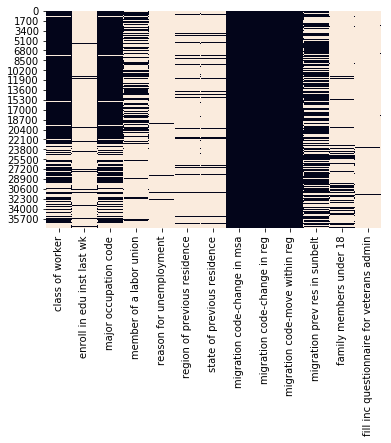

In [14]:
sns.heatmap(null_census.isnull(), cbar=False)

In [15]:
census['migration code-change in msa'].value_counts()

?                   19104
Nonmover            15478
MSA to MSA           1886
NonMSA to nonMSA      439
MSA to nonMSA         114
NonMSA to MSA          96
Abroad to MSA          65
Not identifiable       64
Abroad to nonMSA        8
Name: migration code-change in msa, dtype: int64

In [20]:
import scipy.stats as ss
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [22]:
confusion_matrix = pd.crosstab(census['migration code-change in msa'], census['income'])
cramers_corrected_stat(confusion_matrix)

0.06594863517888182

In [23]:
confusion_matrix = pd.crosstab(census['migration code-change in reg'], census['income'])
cramers_corrected_stat(confusion_matrix)

0.06474598918733648

In [24]:
confusion_matrix = pd.crosstab(census['class of worker'], census['income'])
cramers_corrected_stat(confusion_matrix)

0.2641085447596001

In [25]:
confusion_matrix = pd.crosstab(census['race'], census['income'])
cramers_corrected_stat(confusion_matrix)

0.12360897567265648

In [46]:
corr_matrix = census.corr(method = 'pearson')
incomes = census['income']
cramer_cols = []
cramer_vals = []
pearson_cols = []
pearson_vals = []
cramer_counts = []
pearson_counts = []
for col in list(census.columns.values):
    series = census[col]
    dtype = series.dtype
    if (dtype != np.int64 and dtype != np.float64) or col == "own business or self employed":
        confusion_matrix = pd.crosstab(series, incomes)
        cramer = cramers_corrected_stat(confusion_matrix)
        cramer_cols.append(col)
        cramer_vals.append(cramer)
        cramer_counts.append(len(series)-sum(series.isnull()))
    else:
        pearson = corr_matrix['income'][col]
        pearson_cols.append(col)
        pearson_vals.append(pearson)
        pearson_counts.append(len(series)-sum(series.isnull()))
cramer_dict = {'Feature':cramer_cols,'Cramer Coef.':cramer_vals,'Count':cramer_counts}
cramer_df = pd.DataFrame(cramer_dict)

pearson_dict = {'Feature':pearson_cols,'Pearson Coef.':pearson_vals,'Count':pearson_counts}
pearson_df = pd.DataFrame(pearson_dict)

cramer_df.sort_values(by='Cramer Coef.',axis=0,ascending=False,inplace=True)
print(cramer_df)
pearson_df.sort_values(by='Pearson Coef.',axis=0,ascending=False,inplace=True)
print(pearson_df)

                                      Feature  Cramer Coef.  Count
1                                   education      0.573069  37382
5                       major occupation code      0.528456  28563
15         detailed household and family stat      0.417755  37382
16    detailed household summary in household      0.405074  37382
4                         major industry code      0.377083  37382
12                           tax filer status      0.368011  37382
3                              marital status      0.341098  37382
8                                         sex      0.310995  37382
0                             class of worker      0.264109  28594
10                    reason for unemployment      0.246388    630
28  fill inc questionnaire for veterans admin      0.182658    444
11          full or part time employment stat      0.162522  37382
23                    country of birth father      0.139824  37382
24                    country of birth mother      0.132769  3